In [1]:
import os
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os 
# importing geopy library and Nominatim class
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut 
import geopandas as gpd
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import time
from shapely.geometry import Point
from shapely.ops import nearest_points

/Users/roosfens/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## First steps:

In [2]:
# Leesbaar maken van dataset 
file_path = 'duodata01.csv'
data = pd.read_csv(file_path, delimiter=';')
print(data.head())

   PROVINCIE  BEVOEGD GEZAG NUMMER INSTELLINGSCODE VESTIGINGSCODE  \
0  Flevoland                 30357            26RK         26RK00   
1  Flevoland                 30709            23FD         23FD01   
2  Flevoland                 40077            24EJ         24EJ00   
3  Flevoland                 40077            28BL         28BL00   
4  Flevoland                 40114            12PM         12PM00   

                     VESTIGINGSNAAM       STRAATNAAM HUISNUMMER-TOEVOEGING  \
0      RK Basisschool De Toermalijn             Jade                    49   
1                Shri Laksmi School    Regentesseweg                     1   
2  Islamitische Basisschool Al Iman  Harderwijkoever                     3   
3                         Al-Ihsaan            Schor                     7   
4                Basisschool De Ark        Middenhof                   210   

  POSTCODE PLAATSNAAM  GEMEENTENUMMER  ... RPA-GEBIED NAAM WGR-GEBIED CODE  \
0  3893 EB   ZEEWOLDE              50 

In [3]:
# maken van extra kolom "adress" in dataset 
filtered_data = data[data['GEMEENTENAAM'].isin(['ALMERE'])]
filtered_data['ADRESS']= filtered_data['STRAATNAAM'] + ' ' + filtered_data['HUISNUMMER-TOEVOEGING'].astype(str) + ', ' + filtered_data['POSTCODE'] + ' ' + filtered_data['PLAATSNAAM'] 

print(filtered_data)

     PROVINCIE  BEVOEGD GEZAG NUMMER INSTELLINGSCODE VESTIGINGSCODE  \
1    Flevoland                 30709            23FD         23FD01   
2    Flevoland                 40077            24EJ         24EJ00   
4    Flevoland                 40114            12PM         12PM00   
5    Flevoland                 40114            12XA         12XA00   
6    Flevoland                 40114            13CW         13CW00   
..         ...                   ...             ...            ...   
114  Flevoland                 41676            31TB         31TB00   
115  Flevoland                 41676            32CJ         32CJ00   
154  Flevoland                 42834            31VV         31VV00   
175  Flevoland                 62584            06RM         06RM00   
176  Flevoland                 62584            32AK         32AK00   

                                 VESTIGINGSNAAM                STRAATNAAM  \
1                            Shri Laksmi School             Regentesse

/var/folders/c4/d1hjy4hs55z494dzspybl0br0000gn/T/ipykernel_7534/2620088468.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['ADRESS']= filtered_data['STRAATNAAM'] + ' ' + filtered_data['HUISNUMMER-TOEVOEGING'].astype(str) + ', ' + filtered_data['POSTCODE'] + ' ' + filtered_data['PLAATSNAAM']


## Longitude & Latitude 

In [4]:
# Zorg ervoor dat je 'filtered_data' hebt gedefinieerd als een pandas DataFrame
# Example: filtered_data = pd.DataFrame({'ADRESS': ['Address1', 'Address2']})

# Initialiseer de Nominatim-geocoder
loc = Nominatim(user_agent="Geopy_Library", timeout=10)  # Timeout verhoogd naar 10 seconden

latitudes = []
longitudes = []

def geocode_address(address):
    """Probeer een adres te geocoderen met foutafhandeling en retries."""
    try:
        location = loc.geocode(address)
        return location
    except GeocoderTimedOut:
        print(f"Timeout voor adres: {address}. Opnieuw proberen...")
        return geocode_address(address)  # Probeer opnieuw bij timeout
    except Exception as e:
        print(f"Fout bij geocoderen van {address}: {e}")
        return None

for address in filtered_data['ADRESS']:
    # Voeg een vertraging toe om overbelasting van de server te voorkomen
    time.sleep(1)  # Wacht 1 seconde tussen verzoeken

    # Geocode het adres
    location = geocode_address(address)
    
    # Controleer of er een locatie is gevonden
    if location:
        latitudes.append(location.latitude)
        longitudes.append(location.longitude)
    else:
        latitudes.append(None)
        longitudes.append(None)

# Voeg de resultaten toe aan de DataFrame
filtered_data['latitude'] = latitudes
filtered_data['longitude'] = longitudes

# Debug output: controleer een voorbeeldadres
# Uncomment voor extra debug informatie
# getLoc = geocode_address(filtered_data['ADRESS'][0])
# if getLoc:
#     print("Address:", getLoc.address)
#     print("Latitude:", getLoc.latitude)
#     print("Longitude:", getLoc.longitude)

# Controleer de uiteindelijke DataFrame
filtered_data


/var/folders/c4/d1hjy4hs55z494dzspybl0br0000gn/T/ipykernel_7534/2389180841.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['latitude'] = latitudes
/var/folders/c4/d1hjy4hs55z494dzspybl0br0000gn/T/ipykernel_7534/2389180841.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['longitude'] = longitudes


,PROVINCIE,BEVOEGD GEZAG NUMMER,INSTELLINGSCODE,VESTIGINGSCODE,VESTIGINGSNAAM,STRAATNAAM,HUISNUMMER-TOEVOEGING,POSTCODE,PLAATSNAAM,GEMEENTENUMMER,...,COROPGEBIED CODE,COROPGEBIED NAAM,ONDERWIJSGEBIED CODE,ONDERWIJSGEBIED NAAM,RMC-REGIO CODE,RMC-REGIO NAAM,VAKANTIEREGIO,ADRESS,latitude,longitude
1,Flevoland,30709,23FD,23FD01,Shri Laksmi School,Regentesseweg,1,1312 AA,ALMERE,34,...,40,Flevoland,10,Harderwijk-Amersfoort,18,Flevoland,Noord,"Regentesseweg 1, 1312 AA ALMERE",52.374615,5.211311
2,Flevoland,40077,24EJ,24EJ00,Islamitische Basisschool Al Iman,Harderwijkoever,3,1324 HA,ALMERE,34,...,40,Flevoland,10,Harderwijk-Amersfoort,18,Flevoland,Noord,"Harderwijkoever 3, 1324 HA ALMERE",52.361261,5.209740
4,Flevoland,40114,12PM,12PM00,Basisschool De Ark,Middenhof,210,1354 EV,ALMERE,34,...,40,Flevoland,10,Harderwijk-Amersfoort,18,Flevoland,Noord,"Middenhof 210, 1354 EV ALMERE",52.340464,5.214997
5,Flevoland,40114,12XA,12XA00,Basisschool de Driemaster,Tegelenpad,2,1324 DS,ALMERE,34,...,40,Flevoland,10,Harderwijk-Amersfoort,18,Flevoland,Noord,"Tegelenpad 2, 1324 DS ALMERE",52.360710,5.208042
6,Flevoland,40114,13CW,13CW00,Basisschool de Ichthus,Rijnweg,10,1316 EP,ALMERE,34,...,40,Flevoland,10,Harderwijk-Amersfoort,18,Flevoland,Noord,"Rijnweg 10, 1316 EP ALMERE",52.383498,5.224978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,Flevoland,41676,31TB,31TB00,Montessori Campus 0-18 (primair onderwijs),Rosalind Franklinweg,4,1341 HZ,ALMERE,34,...,40,Flevoland,10,Harderwijk-Amersfoort,18,Flevoland,Noord,"Rosalind Franklinweg 4, 1341 HZ ALMERE",52.366563,5.287467
115,Flevoland,41676,32CJ,32CJ00,De Pauw,Burchard de Volderstraat,19,1349 HJ,ALMERE,34,...,40,Flevoland,10,Harderwijk-Amersfoort,18,Flevoland,Noord,"Burchard de Volderstraat 19, 1349 HJ ALMERE",52.344597,5.313533
154,Flevoland,42834,31VV,31VV00,School van Vrede,Pieter van Damstraat,36,1335 PG,ALMERE,34,...,40,Flevoland,10,Harderwijk-Amersfoort,18,Flevoland,Noord,"Pieter van Damstraat 36, 1335 PG ALMERE",52.404994,5.295516
175,Flevoland,62584,06RM,06RM00,Vrije School Almere,Lierstraat,7,1312 JZ,ALMERE,34,...,40,Flevoland,10,Harderwijk-Amersfoort,18,Flevoland,Noord,"Lierstraat 7, 1312 JZ ALMERE",52.371956,5.193949


## Defining neighborhood boundaries

In [5]:
shp_map = gpd.read_file('/Users/roosfens/Library/CloudStorage/OneDrive-Persoonlijk/documenten/UVA/Jaar 5/Afstudeer Project/Python/cbsgebiedsindelingen2024.gpkg', layer='buurt_gegeneraliseerd')
shp_map.head()

,statcode,jrstatcode,statnaam,gm_code,rubriek,id,geometry
0,BU00340101,2024BU00340101,Centrum Haven Noord,GM0034,buurt,1,"MULTIPOLYGON (((143508.204 483344.282, 143707...."
1,BU00340102,2024BU00340102,Centrum Haven Zuid,GM0034,buurt,2,"MULTIPOLYGON (((143728.650 483029.012, 143730...."
2,BU00340201,2024BU00340201,Rozenwerf en Tuinderswerf,GM0034,buurt,3,"MULTIPOLYGON (((144118.020 483591.859, 144295...."
3,BU00340202,2024BU00340202,Achterwerf,GM0034,buurt,4,"MULTIPOLYGON (((144427.109 483263.953, 144384...."
4,BU00340203,2024BU00340203,Goedewerf en Wittewerf,GM0034,buurt,5,"MULTIPOLYGON (((144267.821 483312.403, 144090...."


In [6]:
shp_map = shp_map.to_crs('EPSG:4289')
shp_map.crs

<Geographic 2D CRS: EPSG:4289>
Name: Amersfoort
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Netherlands - onshore, including Waddenzee, Dutch Wadden Islands and 12-mile offshore coastal zone.
- bounds: (3.2, 50.75, 7.22, 53.7)
Datum: Amersfoort
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

In [7]:
#neighborhood shp of almere (alm)
shp_alm = shp_map[shp_map['gm_code'] == 'GM0034'].reset_index(drop=True)
shp_alm.head()

,statcode,jrstatcode,statnaam,gm_code,rubriek,id,geometry
0,BU00340101,2024BU00340101,Centrum Haven Noord,GM0034,buurt,1,"MULTIPOLYGON (((5.21900 52.33891, 5.22193 52.3..."
1,BU00340102,2024BU00340102,Centrum Haven Zuid,GM0034,buurt,2,"MULTIPOLYGON (((5.22224 52.33608, 5.22228 52.3..."
2,BU00340201,2024BU00340201,Rozenwerf en Tuinderswerf,GM0034,buurt,3,"MULTIPOLYGON (((5.22794 52.34115, 5.23055 52.3..."
3,BU00340202,2024BU00340202,Achterwerf,GM0034,buurt,4,"MULTIPOLYGON (((5.23249 52.33821, 5.23187 52.3..."
4,BU00340203,2024BU00340203,Goedewerf en Wittewerf,GM0034,buurt,5,"MULTIPOLYGON (((5.23015 52.33864, 5.22755 52.3..."


In [8]:
# identifiseren buurt
#pois_at_sch['geometry'] = [Point (xy) for xy in zip(pois_at_sch['shape_pt_lon'], shapes_rtm_bus['shape_pt_lat'])]
geometry = shp_alm['geometry']

#gdf_rtm = gdf_rtm.to_crs('EPSG:4289')
#crs = {'init' :'EPSG:4289'} #EPSG for NL (geodetic: 4298; cartesioan: 28992)
#crs = buurt_id.crs
crs = shp_alm.crs
gdf = gpd.GeoDataFrame(filtered_data, crs=crs, geometry=geometry)

#grid_buurt = gpd.sjoin(gdf, shp_ams, op='within')
filtered_data = gpd.sjoin(gdf, shp_alm, how='inner', op='intersects')
filtered_data = pd.DataFrame(filtered_data).reset_index(drop=True)
filtered_data = filtered_data.drop_duplicates(['VESTIGINGSNAAM'], keep='first').reset_index(drop=True)
filtered_data.head()

/Users/roosfens/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py:3490: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,PROVINCIE,BEVOEGD GEZAG NUMMER,INSTELLINGSCODE,VESTIGINGSCODE,VESTIGINGSNAAM,STRAATNAAM,HUISNUMMER-TOEVOEGING,POSTCODE,PLAATSNAAM,GEMEENTENUMMER,...,latitude,longitude,geometry,index_right,statcode,jrstatcode,statnaam,gm_code,rubriek,id
0,Flevoland,30709,23FD,23FD01,Shri Laksmi School,Regentesseweg,1,1312 AA,ALMERE,34,...,52.374615,5.211311,"MULTIPOLYGON (((5.22224 52.33608, 5.22228 52.3...",13,BU00340403,2024BU00340403,Rietmeent en Dijkmeent,GM0034,buurt,14
1,Flevoland,40077,24EJ,24EJ00,Islamitische Basisschool Al Iman,Harderwijkoever,3,1324 HA,ALMERE,34,...,52.361261,5.209740,"MULTIPOLYGON (((5.22794 52.34115, 5.23055 52.3...",3,BU00340202,2024BU00340202,Achterwerf,GM0034,buurt,4
2,Flevoland,40114,12PM,12PM00,Basisschool De Ark,Middenhof,210,1354 EV,ALMERE,34,...,52.340464,5.214997,"MULTIPOLYGON (((5.23015 52.33864, 5.22755 52.3...",3,BU00340202,2024BU00340202,Achterwerf,GM0034,buurt,4
3,Flevoland,40114,12XA,12XA00,Basisschool de Driemaster,Tegelenpad,2,1324 DS,ALMERE,34,...,52.360710,5.208042,"MULTIPOLYGON (((5.22556 52.33917, 5.22228 52.3...",4,BU00340203,2024BU00340203,Goedewerf en Wittewerf,GM0034,buurt,5
4,Flevoland,40114,13CW,13CW00,Basisschool de Ichthus,Rijnweg,10,1316 EP,ALMERE,34,...,52.383498,5.224978,"MULTIPOLYGON (((5.22456 52.33983, 5.22193 52.3...",5,BU00340204,2024BU00340204,Schoolwerf,GM0034,buurt,6


In [9]:
# nieuw dataframe maken met alleen school en buurt 
df = filtered_data[['VESTIGINGSNAAM', 'statnaam', 'statcode', 'VESTIGINGSCODE']].copy()
df.columns = ['school' , 'neighborhood', 'statcode', 'locationcode']
df.head()

,school,neighborhood,statcode,locationcode
0,Shri Laksmi School,Rietmeent en Dijkmeent,BU00340403,23FD01
1,Islamitische Basisschool Al Iman,Achterwerf,BU00340202,24EJ00
2,Basisschool De Ark,Achterwerf,BU00340202,12PM00
3,Basisschool de Driemaster,Goedewerf en Wittewerf,BU00340203,12XA00
4,Basisschool de Ichthus,Schoolwerf,BU00340204,13CW00


In [10]:
# # scenario 1 csv inladen 
scenario_1 = pd.read_csv("scenario_1 Alm.csv")
scenario_1.head(100)

,Unnamed: 0,locationcode,students,school,neighborhood,statcode,n_western,n_nonwestern,n_population,p_western,p_nonwestern,n_std_western,n_std_nonwestern,di_per_school
0,0,06RM00,406.0,Vrije School Almere,Bloemenbuurt Zuid,BU00344803,810,490,1295,62.548263,37.837838,253.945946,153.621622,0.000834
1,1,12PM00,164.0,Basisschool De Ark,Achterwerf,BU00340202,535,150,680,78.676471,22.058824,129.029412,36.176471,0.002808
2,2,12QK00,226.0,Rooms Katholieke Basisschool Panta Rhei,Parkwijk Zuidwest,BU00342004,480,110,600,80.000000,18.333333,180.800000,41.433333,0.004650
3,3,12XA00,163.0,Basisschool de Driemaster,Goedewerf en Wittewerf,BU00340203,345,220,560,61.607143,39.285714,100.419643,64.035714,0.000583
4,4,13CW00,111.0,Basisschool de Ichthus,Schoolwerf,BU00340204,305,205,510,59.803922,40.196078,66.382353,44.617647,0.000562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,65,31TB00,115.0,Montessori Campus 0-18 (primair onderwijs),Muziekwijk Z.-Noord,BU00342901,870,930,1805,48.199446,51.523546,55.429363,59.252078,0.002167
66,66,31UY00,99.0,De Verbeelding,Rozenwerf en Tuinderswerf,BU00340201,430,160,585,73.504274,27.350427,72.769231,27.076923,0.001069
67,67,31VV00,16.0,School van Vrede,Seizoenenbuurt West,BU00344303,1400,1000,2395,58.455115,41.753653,9.352818,6.680585,0.000110
68,68,31VY00,43.0,IKC De Woudreus,Waterwijk Zuid,BU00342203,680,310,990,68.686869,31.313131,29.535354,13.464646,0.000243


##  Scenario 2: 2km radius 

In [11]:
# Inladen nieuwe dataset GEO_DATA met gegevens over wijken 
# Pad naar het bestand
file_path = "/Users/roosfens/Library/CloudStorage/OneDrive-Persoonlijk/documenten/UVA/Jaar 5/Afstudeer Project/Python/wijkenbuurten_2023_v2.gpkg"

# Laad het GeoPackage-bestand
geo_data = gpd.read_file(file_path)

# Filter alleen buurten in Almere
almere_data = geo_data[geo_data["gemeentenaam"] == "Almere"]

# Nieuwe CRS 
almere_data = almere_data.to_crs('EPSG:4289')
almere_data

almere_data.head()

,buurtcode,buurtnaam,wijkcode,gemeentecode,gemeentenaam,indelingswijziging_wijken_en_buurten,water,meest_voorkomende_postcode,dekkingspercentage,omgevingsadressendichtheid,...,afstand_tot_open_nat_natuurlijk_terrein,afstand_tot_semiopenbaar_groen_totaal,afstand_tot_sportterrein,afstand_tot_volkstuin,afstand_tot_verblijfsrecreatief_terrein,afstand_tot_recreatief_binnenwater,afstand_tot_begraafplaats,jrstatcode,jaar,geometry
1,BU00349997,Groot binnenwater,WK003499,GM0034,Almere,-99997,JA,-99997,-99997,-99997,...,-99995.0,-99995.0,-99995.0,-99995.0,-99995.0,-99995.0,-99995.0,2023BU00349997,2023,"MULTIPOLYGON (((5.31560 52.30340, 5.31433 52.3..."
245,BU00340101,Centrum Haven Noord,WK003401,GM0034,Almere,1,NEE,1354,2,2050,...,-99995.0,-99995.0,-99995.0,-99995.0,-99995.0,-99995.0,-99995.0,2023BU00340101,2023,"MULTIPOLYGON (((5.21899 52.33891, 5.21900 52.3..."
246,BU00340102,Centrum Haven Zuid,WK003401,GM0034,Almere,1,NEE,1353,5,1559,...,-99995.0,-99995.0,-99995.0,-99995.0,-99995.0,-99995.0,-99995.0,2023BU00340102,2023,"MULTIPOLYGON (((5.21147 52.33259, 5.21147 52.3..."
247,BU00340201,Rozenwerf en Tuinderswerf,WK003402,GM0034,Almere,1,NEE,1355,1,2059,...,-99995.0,-99995.0,-99995.0,-99995.0,-99995.0,-99995.0,-99995.0,2023BU00340201,2023,"MULTIPOLYGON (((5.22348 52.34288, 5.22349 52.3..."
248,BU00340202,Achterwerf,WK003402,GM0034,Almere,1,NEE,1357,1,1781,...,-99995.0,-99995.0,-99995.0,-99995.0,-99995.0,-99995.0,-99995.0,2023BU00340202,2023,"MULTIPOLYGON (((5.23107 52.33887, 5.23109 52.3..."


In [12]:
gdf.crs

<Geographic 2D CRS: EPSG:4289>
Name: Amersfoort
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Netherlands - onshore, including Waddenzee, Dutch Wadden Islands and 12-mile offshore coastal zone.
- bounds: (3.2, 50.75, 7.22, 53.7)
Datum: Amersfoort
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

In [13]:
almere_data.crs

<Geographic 2D CRS: EPSG:4289>
Name: Amersfoort
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Netherlands - onshore, including Waddenzee, Dutch Wadden Islands and 12-mile offshore coastal zone.
- bounds: (3.2, 50.75, 7.22, 53.7)
Datum: Amersfoort
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

In [14]:
schools = gdf[['VESTIGINGSNAAM', 'VESTIGINGSCODE', 'latitude', 'longitude', 'geometry']]
schools.columns = ['school', 'locationcode', 'latitude_school', 'longitude_school', 'geometry_school']
schools = schools[~schools['latitude_school'].isna()]
schools = schools[~schools['longitude_school'].isna()].reset_index(drop=True)
schools.head(2)

,school,locationcode,latitude_school,longitude_school,geometry_school
0,Shri Laksmi School,23FD01,52.374615,5.211311,"MULTIPOLYGON (((5.22224 52.33608, 5.22228 52.3..."
1,Islamitische Basisschool Al Iman,24EJ00,52.361261,5.209740,"MULTIPOLYGON (((5.22794 52.34115, 5.23055 52.3..."


In [15]:
neighborhood = almere_data[['buurtcode', 'buurtnaam', 'geometry']].reset_index(drop=True)
neighborhood.columns = ['neighborhoodcode', 'neighborhood', 'geometry_neighborhood']
neighborhood['longitude_neighborhood'] = neighborhood['geometry_neighborhood'].centroid.x
neighborhood['latitude_neighborhood'] = neighborhood['geometry_neighborhood'].centroid.y
neighborhood.head(2)

/var/folders/c4/d1hjy4hs55z494dzspybl0br0000gn/T/ipykernel_7534/942399992.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  neighborhood['longitude_neighborhood'] = neighborhood['geometry_neighborhood'].centroid.x
/var/folders/c4/d1hjy4hs55z494dzspybl0br0000gn/T/ipykernel_7534/942399992.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  neighborhood['latitude_neighborhood'] = neighborhood['geometry_neighborhood'].centroid.y


,neighborhoodcode,neighborhood,geometry_neighborhood,longitude_neighborhood,latitude_neighborhood
0,BU00349997,Groot binnenwater,"MULTIPOLYGON (((5.31560 52.30340, 5.31433 52.3...",5.153787,52.448448
1,BU00340101,Centrum Haven Noord,"MULTIPOLYGON (((5.21899 52.33891, 5.21900 52.3...",5.219201,52.337198


## Dataframe schools_buurt: distance km buurt naar school 

In [16]:
# distance van buurt naar school berekenen 
from itertools import product
import geopy.distance

schools_neighborhood = pd.DataFrame(product(neighborhood['neighborhoodcode'], schools['locationcode']))
schools_neighborhood.columns = ['neighborhoodcode', 'locationcode']

schools_neighborhood = pd.merge(schools_neighborhood, schools, on='locationcode')
schools_neighborhood = pd.merge(schools_neighborhood, neighborhood, on='neighborhoodcode')
schools_neighborhood['distance_km'] = schools_neighborhood.apply(lambda row: geopy.distance.distance((row['latitude_school'], row['longitude_school']), 
                                                                                    (row['latitude_neighborhood'], row['longitude_neighborhood'])), 
                                                                                    axis=1)
schools_neighborhood

,neighborhoodcode,locationcode,school,latitude_school,longitude_school,geometry_school,neighborhood,geometry_neighborhood,longitude_neighborhood,latitude_neighborhood,distance_km
0,BU00349997,23FD01,Shri Laksmi School,52.374615,5.211311,"MULTIPOLYGON (((5.22224 52.33608, 5.22228 52.3...",Groot binnenwater,"MULTIPOLYGON (((5.31560 52.30340, 5.31433 52.3...",5.153787,52.448448,9.100633818219478 km
1,BU00349997,24EJ00,Islamitische Basisschool Al Iman,52.361261,5.209740,"MULTIPOLYGON (((5.22794 52.34115, 5.23055 52.3...",Groot binnenwater,"MULTIPOLYGON (((5.31560 52.30340, 5.31433 52.3...",5.153787,52.448448,10.422288035521753 km
2,BU00349997,12PM00,Basisschool De Ark,52.340464,5.214997,"MULTIPOLYGON (((5.23015 52.33864, 5.22755 52.3...",Groot binnenwater,"MULTIPOLYGON (((5.31560 52.30340, 5.31433 52.3...",5.153787,52.448448,12.717802317127928 km
3,BU00349997,12XA00,Basisschool de Driemaster,52.360710,5.208042,"MULTIPOLYGON (((5.22556 52.33917, 5.22228 52.3...",Groot binnenwater,"MULTIPOLYGON (((5.31560 52.30340, 5.31433 52.3...",5.153787,52.448448,10.437969816466408 km
4,BU00349997,13CW00,Basisschool de Ichthus,52.383498,5.224978,"MULTIPOLYGON (((5.22456 52.33983, 5.22193 52.3...",Groot binnenwater,"MULTIPOLYGON (((5.31560 52.30340, 5.31433 52.3...",5.153787,52.448448,8.700433408192138 km
...,...,...,...,...,...,...,...,...,...,...,...
17442,BU00349615,31TB00,Montessori Campus 0-18 (primair onderwijs),52.366563,5.287467,"MULTIPOLYGON (((5.20213 52.37407, 5.20280 52.3...",Overig Almere Pampus (brt),"MULTIPOLYGON (((5.15906 52.39585, 5.15906 52.3...",5.149594,52.377310,9.465962846788333 km
17443,BU00349615,32CJ00,De Pauw,52.344597,5.313533,"MULTIPOLYGON (((5.20296 52.37330, 5.20465 52.3...",Overig Almere Pampus (brt),"MULTIPOLYGON (((5.15906 52.39585, 5.15906 52.3...",5.149594,52.377310,11.746443209243504 km
17444,BU00349615,31VV00,School van Vrede,52.404994,5.295516,"MULTIPOLYGON (((5.28661 52.40930, 5.28964 52.4...",Overig Almere Pampus (brt),"MULTIPOLYGON (((5.15906 52.39585, 5.15906 52.3...",5.149594,52.377310,10.40067723721526 km
17445,BU00349615,06RM00,Vrije School Almere,52.371956,5.193949,"MULTIPOLYGON (((5.28762 52.38671, 5.28139 52.3...",Overig Almere Pampus (brt),"MULTIPOLYGON (((5.15906 52.39585, 5.15906 52.3...",5.149594,52.377310,3.0788814467471 km


## Dataframe schools_buurt_within_2km

In [17]:
# Filter op buurten binnen 2 km van de scholen
schools_neighborhood_within_2km = schools_neighborhood.loc[schools_neighborhood['distance_km'] <= 2]

# Nieuw dataframe met alleen buurten binnen 2 km
schools_neighborhood_within_2km.reset_index(drop=True, inplace=True)

# Controleer het nieuwe dataframe
schools_neighborhood_within_2km

,neighborhoodcode,locationcode,school,latitude_school,longitude_school,geometry_school,neighborhood,geometry_neighborhood,longitude_neighborhood,latitude_neighborhood,distance_km
0,BU00340101,12PM00,Basisschool De Ark,52.340464,5.214997,"MULTIPOLYGON (((5.23015 52.33864, 5.22755 52.3...",Centrum Haven Noord,"MULTIPOLYGON (((5.21899 52.33891, 5.21900 52.3...",5.219201,52.337198,0.46281304616805163 km
1,BU00340101,13NH00,Basisschool de Regenboog,52.339791,5.237295,"MULTIPOLYGON (((5.21578 52.34177, 5.21952 52.3...",Centrum Haven Noord,"MULTIPOLYGON (((5.21899 52.33891, 5.21900 52.3...",5.219201,52.337198,1.2665875808006228 km
2,BU00340101,13IU00,RK Jenaplanschool De Sterrenzee,52.343784,5.225141,"MULTIPOLYGON (((5.25617 52.37509, 5.25054 52.3...",Centrum Haven Noord,"MULTIPOLYGON (((5.21899 52.33891, 5.21900 52.3...",5.219201,52.337198,0.8372121137344953 km
3,BU00340101,16KK00,Basisschool De Polderhof,52.340380,5.217234,"MULTIPOLYGON (((5.26617 52.38140, 5.27169 52.3...",Centrum Haven Noord,"MULTIPOLYGON (((5.21899 52.33891, 5.21900 52.3...",5.219201,52.337198,0.3785801267039617 km
4,BU00340101,16ML00,Basisschool Klaverweide,52.334628,5.234322,"MULTIPOLYGON (((5.26957 52.37854, 5.27432 52.3...",Centrum Haven Noord,"MULTIPOLYGON (((5.21899 52.33891, 5.21900 52.3...",5.219201,52.337198,1.0696354776708243 km
...,...,...,...,...,...,...,...,...,...,...,...
2443,BU00347901,31AZ00,Algemeen Bijzondere Basisschool Het Universum,52.358878,5.285171,"MULTIPOLYGON (((5.18129 52.36952, 5.18000 52.3...",Twentsekant (brt),"MULTIPOLYGON (((5.29235 52.37429, 5.29240 52.3...",5.287644,52.367598,0.9849058121135796 km
2444,BU00347901,31TB00,Montessori Campus 0-18 (primair onderwijs),52.366563,5.287467,"MULTIPOLYGON (((5.20213 52.37407, 5.20280 52.3...",Twentsekant (brt),"MULTIPOLYGON (((5.29235 52.37429, 5.29240 52.3...",5.287644,52.367598,0.11586927172449067 km
2445,BU00348502,31LN00,De Verwondering,52.359288,5.286330,"MULTIPOLYGON (((5.23068 52.34942, 5.22631 52.3...",Overig Almere Hout West,"MULTIPOLYGON (((5.27001 52.36089, 5.27020 52.3...",5.279873,52.342663,1.9015384235432566 km
2446,BU00348502,31AZ00,Algemeen Bijzondere Basisschool Het Universum,52.358878,5.285171,"MULTIPOLYGON (((5.18129 52.36952, 5.18000 52.3...",Overig Almere Hout West,"MULTIPOLYGON (((5.27001 52.36089, 5.27020 52.3...",5.279873,52.342663,1.8400683054908118 km


# DF: Scenario_1 relevant + scenario_2

In [18]:
# Selecteer de benodigde kolommen uit df_schools
scenario_1_relevant = scenario_1[['school', 'students', 'p_western', 'p_nonwestern', 'n_std_western', 'n_std_nonwestern']]

# Merge df_schools met schools_buurt_within_2km op basis van de kolom 'School'
merged_df = pd.merge(
    schools_neighborhood_within_2km,  # Linker dataframe
    scenario_1_relevant,       # Rechter dataframe (met alleen relevante kolommen)
    on='school',               # Mergen op kolom 'School'
    how='left'                 # 'left' join om alle rijen uit schools_buurt_within_2km te behouden
)

merged_df.head(1000)

,neighborhoodcode,locationcode,school,latitude_school,longitude_school,geometry_school,neighborhood,geometry_neighborhood,longitude_neighborhood,latitude_neighborhood,distance_km,students,p_western,p_nonwestern,n_std_western,n_std_nonwestern
0,BU00340101,12PM00,Basisschool De Ark,52.340464,5.214997,"MULTIPOLYGON (((5.23015 52.33864, 5.22755 52.3...",Centrum Haven Noord,"MULTIPOLYGON (((5.21899 52.33891, 5.21900 52.3...",5.219201,52.337198,0.46281304616805163 km,164.0,78.676471,22.058824,129.029412,36.176471
1,BU00340101,13NH00,Basisschool de Regenboog,52.339791,5.237295,"MULTIPOLYGON (((5.21578 52.34177, 5.21952 52.3...",Centrum Haven Noord,"MULTIPOLYGON (((5.21899 52.33891, 5.21900 52.3...",5.219201,52.337198,1.2665875808006228 km,452.0,49.056604,50.943396,221.735849,230.264151
2,BU00340101,13IU00,RK Jenaplanschool De Sterrenzee,52.343784,5.225141,"MULTIPOLYGON (((5.25617 52.37509, 5.25054 52.3...",Centrum Haven Noord,"MULTIPOLYGON (((5.21899 52.33891, 5.21900 52.3...",5.219201,52.337198,0.8372121137344953 km,130.0,80.000000,18.333333,104.000000,23.833333
3,BU00340101,16KK00,Basisschool De Polderhof,52.340380,5.217234,"MULTIPOLYGON (((5.26617 52.38140, 5.27169 52.3...",Centrum Haven Noord,"MULTIPOLYGON (((5.21899 52.33891, 5.21900 52.3...",5.219201,52.337198,0.3785801267039617 km,197.0,55.357143,44.940476,109.053571,88.532738
4,BU00340101,16ML00,Basisschool Klaverweide,52.334628,5.234322,"MULTIPOLYGON (((5.26957 52.37854, 5.27432 52.3...",Centrum Haven Noord,"MULTIPOLYGON (((5.21899 52.33891, 5.21900 52.3...",5.219201,52.337198,1.0696354776708243 km,267.0,46.929825,53.070175,125.302632,141.697368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,BU00342603,17DA00,Openbare basisschool Digitalis,52.382688,5.207991,"MULTIPOLYGON (((5.21302 52.37726, 5.21446 52.3...",Kruidenwijk Noordoost,"MULTIPOLYGON (((5.21208 52.38660, 5.21210 52.3...",5.209465,52.383799,0.15917163870069392 km,128.0,33.412322,66.587678,42.767773,85.232227
996,BU00342603,17DA03,Openbare basisschool Digitalis,52.382859,5.207022,"MULTIPOLYGON (((5.19748 52.38573, 5.19614 52.3...",Kruidenwijk Noordoost,"MULTIPOLYGON (((5.21208 52.38660, 5.21210 52.3...",5.209465,52.383799,0.19651769470058253 km,128.0,33.412322,66.587678,42.767773,85.232227
997,BU00342603,21KO00,Openbare basisschool De Heliotroop,52.382794,5.197390,"MULTIPOLYGON (((5.20321 52.38086, 5.20836 52.3...",Kruidenwijk Noordoost,"MULTIPOLYGON (((5.21208 52.38660, 5.21210 52.3...",5.209465,52.383799,0.8297519521070335 km,272.0,45.255474,55.474453,123.094891,150.890511
998,BU00342603,06RM00,Vrije School Almere,52.371956,5.193949,"MULTIPOLYGON (((5.28762 52.38671, 5.28139 52.3...",Kruidenwijk Noordoost,"MULTIPOLYGON (((5.21208 52.38660, 5.21210 52.3...",5.209465,52.383799,1.6890605470201794 km,406.0,62.548263,37.837838,253.945946,153.621622


In [19]:
# maak datafile aan van je eigen gevonden gegevens 
#merged_df.to_csv('merged_df.csv')

In [20]:
scenario_1_relevant[scenario_1_relevant['school']=='Algemeen Bijzondere Basisschool Het Universum']

,school,students,p_western,p_nonwestern,n_std_western,n_std_nonwestern
60,Algemeen Bijzondere Basisschool Het Universum,432.0,NaN,NaN,NaN,NaN


## Dataframe merged_df totaal

In [21]:
# Stap 1: Filter buurten binnen een straal van 2 km van elke school
schools_within_2km = merged_df[merged_df['distance_km'] <= 2]

# Stap 2: Bereken de gemiddelde westerse en niet-westerse proporties per school
average_proportions = (
    schools_within_2km.groupby('school')
    .agg(
        average_western=('p_western', 'mean'),  # Gemiddelde westerse proportie
        average_nonwestern=('p_nonwestern', 'mean')  # Gemiddelde niet-westerse proportie
    )
)

# # Stap 3: Voeg de berekende gemiddelden toe als nieuwe kolommen in merged_df
# merged_df['average_western'] = merged_df['school'].map(average_proportions['average_western'])
# merged_df['average_nonwestern'] = merged_df['school'].map(average_proportions['average_nonwester'])

scenario_2 = pd.merge(scenario_1_relevant[['school', 'students']], average_proportions, on = 'school')

#Step 4: insert line for missing value
# scenario_2.loc[-1] = ['Algemeen Bijzondere Basisschool Het Universum',',4]

# Controleer het resultaat
scenario_2.head()

,school,students,average_western,average_nonwestern
0,Vrije School Almere,406.0,62.548263,37.837838
1,Basisschool De Ark,164.0,78.676471,22.058824
2,Rooms Katholieke Basisschool Panta Rhei,226.0,80.000000,18.333333
3,Basisschool de Driemaster,163.0,61.607143,39.285714
4,Basisschool de Ichthus,111.0,59.803922,40.196078


In [22]:
# Bereken het aantal westerse en niet-westerse leerlingen
scenario_2['n_western'] = scenario_2['average_western'] * scenario_2['students'] / 100  # Aantal westerse leerlingen
scenario_2['n_nonwestern'] = scenario_2['average_nonwestern'] * scenario_2['students'] / 100  # Aantal niet-westerse leerlingen

# Controleer het resultaat
scenario_2[['school', 'students', 'average_western', 'average_nonwestern', 'n_western', 'n_nonwestern']].head()

,school,students,average_western,average_nonwestern,n_western,n_nonwestern
0,Vrije School Almere,406.0,62.548263,37.837838,253.945946,153.621622
1,Basisschool De Ark,164.0,78.676471,22.058824,129.029412,36.176471
2,Rooms Katholieke Basisschool Panta Rhei,226.0,80.000000,18.333333,180.800000,41.433333
3,Basisschool de Driemaster,163.0,61.607143,39.285714,100.419643,64.035714
4,Basisschool de Ichthus,111.0,59.803922,40.196078,66.382353,44.617647


In [23]:
# Stap 1: Bereken de totale aantallen westerse en niet-westerse studenten in elke school 
total_western = scenario_2['n_western'].sum()
total_nonwestern = scenario_2['n_nonwestern'].sum()

# Stap 2: Functie om de dissimilarity index per school te berekenen
def compute_di_per_school(row, total_western, total_nonwestern):
    school_western_ratio = row['n_western'] / total_western
    school_nonwestern_ratio = row['n_nonwestern'] / total_nonwestern
    return 0.5 * abs(school_western_ratio - school_nonwestern_ratio)

# Stap 3: Bereken de dissimilarity index en voeg deze toe aan de dataframe
scenario_2['dissimilarity_index'] = scenario_2.apply(
    compute_di_per_school, 
    axis=1, 
    args=(total_western, total_nonwestern)
)

# # Stap 4: Bereken gemiddelde dissimilarity index per school
# average_dissimilarity_index = (
#     merged_df.groupby('School')['dissimilarity_index'].mean().rename('average_dissimilarity_index')
# )

# # Stap 5: Voeg de gemiddelde dissimilarity index toe aan merged_df
# merged_df['dissimilarity_index'] = merged_df['School'].map(average_dissimilarity_index)

scenario_2


,school,students,average_western,average_nonwestern,n_western,n_nonwestern,dissimilarity_index
0,Vrije School Almere,406.0,62.548263,37.837838,253.945946,153.621622,0.000919
1,Basisschool De Ark,164.0,78.676471,22.058824,129.029412,36.176471,0.002813
2,Rooms Katholieke Basisschool Panta Rhei,226.0,80.000000,18.333333,180.800000,41.433333,0.004666
3,Basisschool de Driemaster,163.0,61.607143,39.285714,100.419643,64.035714,0.000621
4,Basisschool de Ichthus,111.0,59.803922,40.196078,66.382353,44.617647,0.000590
...,...,...,...,...,...,...,...
64,Montessori Campus 0-18 (primair onderwijs),115.0,48.199446,51.523546,55.429363,59.252078,0.002215
65,De Verbeelding,99.0,73.504274,27.350427,72.769231,27.076923,0.001064
66,School van Vrede,16.0,58.455115,41.753653,9.352818,6.680585,0.000114
67,IKC De Woudreus,43.0,68.686869,31.313131,29.535354,13.464646,0.000238


In [24]:
# Stap 1: Functie om de gemiddelde afstand te berekenen tussen 
# functie berekent gemiddelde afstand tussen school en buurt in schools_buurt_within_2km (radius 2km)
def compute_average_distance_within_2km(school_geometry, neighborhood_geometries):
    distances = [
        school_geometry.distance(buurt_geometry)
        for neighborhood_geometry in neighborhood_geometries
    ]
    if distances:
        return sum(distances) / len(distances)  # Gemiddelde afstand
    else:
        return None  # Geen buurten binnen 2 km

# Stap 2: Bereken gemiddelde afstand voor elke school
# voor elke school in df wordt gecontroleerd welke buurt binnen 2km ligt en gemiddelde afstand 
def calculate_distances(df):
    average_distances = []
    
    for _, school_row in df.iterrows():
        school_geometry = school_row['geometry_school']
        
        # Filter buurten binnen 2 km uit 'schools_buurt_within_2km'
        neighborhood_within_2km = schools_neighborhood_within_2km[
            schools_neighborhood_within_2km['geometry_school'] == school_geometry
        ]['geometry_neighborhood']
        
        # Bereken gemiddelde afstand
        avg_distance = compute_average_distance_within_2km(school_geometry, neighborhood_within_2km)
        average_distances.append(avg_distance)
    
    return average_distances



# Stap 3: Bereken de gemiddelde westerse en niet-westerse proporties per school
schools_neighborhood_within_2km['distance'] = schools_neighborhood_within_2km['distance_km'].astype(str).str[:-3].astype(float)

average_distance = (
    schools_neighborhood_within_2km.groupby('school')
    .agg(
        avg_distance=('distance', 'mean')  # Gemiddelde westerse proportie
        
    )
)

# Step 4: merge scenario 2 with average 
scenario_2 = pd.merge(scenario_2, average_distance, on ='school') 

scenario_2 

/var/folders/c4/d1hjy4hs55z494dzspybl0br0000gn/T/ipykernel_7534/875990773.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  schools_neighborhood_within_2km['distance'] = schools_neighborhood_within_2km['distance_km'].astype(str).str[:-3].astype(float)


,school,students,average_western,average_nonwestern,n_western,n_nonwestern,dissimilarity_index,avg_distance
0,Vrije School Almere,406.0,62.548263,37.837838,253.945946,153.621622,0.000919,1.228021
1,Basisschool De Ark,164.0,78.676471,22.058824,129.029412,36.176471,0.002813,1.011031
2,Rooms Katholieke Basisschool Panta Rhei,226.0,80.000000,18.333333,180.800000,41.433333,0.004666,1.309398
3,Basisschool de Driemaster,163.0,61.607143,39.285714,100.419643,64.035714,0.000621,1.386070
4,Basisschool de Ichthus,111.0,59.803922,40.196078,66.382353,44.617647,0.000590,1.265812
...,...,...,...,...,...,...,...,...
64,Montessori Campus 0-18 (primair onderwijs),115.0,48.199446,51.523546,55.429363,59.252078,0.002215,1.326675
65,De Verbeelding,99.0,73.504274,27.350427,72.769231,27.076923,0.001064,1.361633
66,School van Vrede,16.0,58.455115,41.753653,9.352818,6.680585,0.000114,1.243100
67,IKC De Woudreus,43.0,68.686869,31.313131,29.535354,13.464646,0.000238,1.250266


In [25]:
print('Segregation level at schools in Almere based on Dissimilarity Index:', scenario_2['dissimilarity_index'].sum())

Segregation level at schools in Almere based on Dissimilarity Index: 0.29005321155503255


In [26]:
# merged_new = scenario_2.copy()
# merged_new['dissimilarity_index']= merged_new['dissimilarity_index']*100
# merged_new

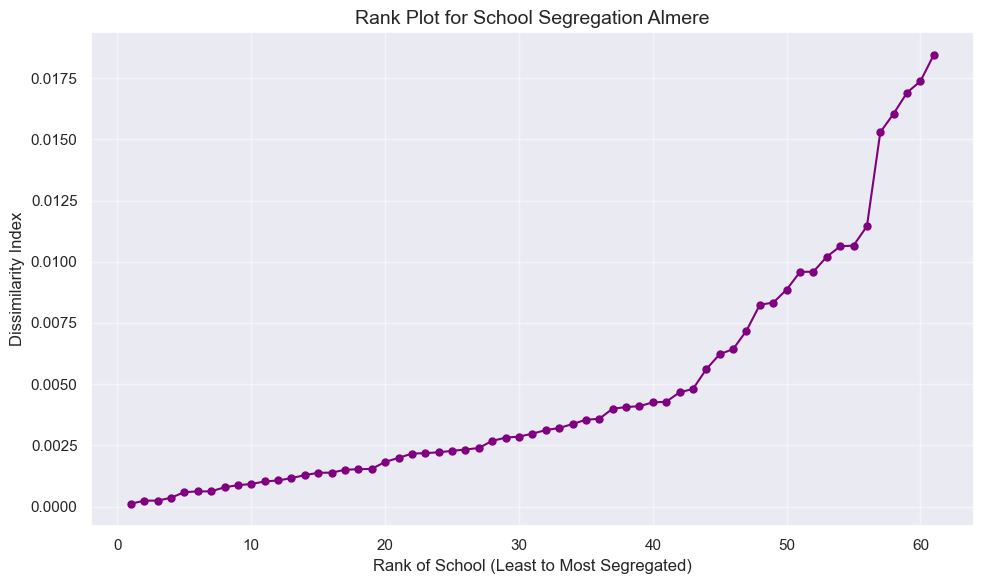

In [27]:
# Sorteren van scholen op basis van de dissimilarity index in merged_df
merged_df_plot = scenario_2.sort_values(by='dissimilarity_index', ascending=True)
merged_df_plot =merged_df_plot[merged_df_plot['dissimilarity_index'].notna()]

# Toevoegen van een rank kolom op basis van de gesorteerde waarden
merged_df_plot['rank'] = range(1, len(merged_df_plot) + 1)

# Plot maken
plt.figure(figsize=(10, 6))
plt.plot(merged_df_plot['rank'], merged_df_plot['dissimilarity_index'], marker='o', linestyle='-', markersize=5, color='purple')

# Assen labels en titel
plt.xlabel('Rank of School (Least to Most Segregated)', fontsize=12)
plt.ylabel('Dissimilarity Index', fontsize=12)
plt.title('Rank Plot for School Segregation Almere', fontsize=14)

# Grid toevoegen voor betere leesbaarheid
plt.grid(alpha=0.5)

# Layout aanpassen voor betere weergave
plt.tight_layout()

# Plot tonen

#plt.savefig("rank_scenario2_almere.png", dpi=300, bbox_inches='tight')  # Hoge resolutie
plt.show()

In [28]:
merged_df_plot

,school,students,average_western,average_nonwestern,n_western,n_nonwestern,dissimilarity_index,avg_distance,rank
66,School van Vrede,16.0,58.455115,41.753653,9.352818,6.680585,0.000114,1.243100,1
67,IKC De Woudreus,43.0,68.686869,31.313131,29.535354,13.464646,0.000238,1.250266,2
68,Vrijeschool Oosterwold,107.0,62.548263,37.837838,66.926641,40.486486,0.000242,1.138025,3
18,De Tjasker,176.0,62.730627,37.638376,110.405904,66.243542,0.000357,1.254913,4
4,Basisschool de Ichthus,111.0,59.803922,40.196078,66.382353,44.617647,0.000590,1.265812,5
...,...,...,...,...,...,...,...,...,...
40,De Omnibus,568.0,86.624204,14.012739,492.025478,79.592357,0.015296,1.334696,57
44,OBS Letterland,462.0,90.625000,6.250000,418.687500,28.875000,0.016059,1.303742,58
45,OBS De Archipel,671.0,43.984962,56.766917,295.139098,380.906015,0.016916,1.093476,59
55,De Droomspiegel,503.0,100.000000,100.000000,503.000000,503.000000,0.017382,1.116811,60


In [29]:
scenario_2_accessibility=scenario_2[scenario_2['school'].isin(merged_df_plot['school'])]
scenario_2_accessibility

,school,students,average_western,average_nonwestern,n_western,n_nonwestern,dissimilarity_index,avg_distance
0,Vrije School Almere,406.0,62.548263,37.837838,253.945946,153.621622,0.000919,1.228021
1,Basisschool De Ark,164.0,78.676471,22.058824,129.029412,36.176471,0.002813,1.011031
2,Rooms Katholieke Basisschool Panta Rhei,226.0,80.000000,18.333333,180.800000,41.433333,0.004666,1.309398
3,Basisschool de Driemaster,163.0,61.607143,39.285714,100.419643,64.035714,0.000621,1.386070
4,Basisschool de Ichthus,111.0,59.803922,40.196078,66.382353,44.617647,0.000590,1.265812
...,...,...,...,...,...,...,...,...
64,Montessori Campus 0-18 (primair onderwijs),115.0,48.199446,51.523546,55.429363,59.252078,0.002215,1.326675
65,De Verbeelding,99.0,73.504274,27.350427,72.769231,27.076923,0.001064,1.361633
66,School van Vrede,16.0,58.455115,41.753653,9.352818,6.680585,0.000114,1.243100
67,IKC De Woudreus,43.0,68.686869,31.313131,29.535354,13.464646,0.000238,1.250266


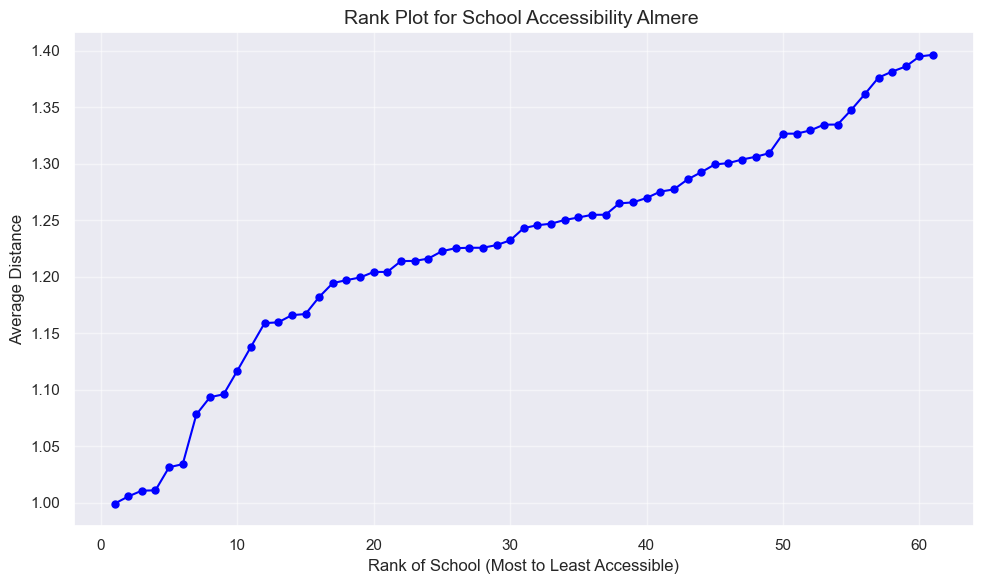

In [30]:
# Sorteren van scholen op basis van de gemiddelde afstand
scenario_2_accessibility = scenario_2_accessibility.sort_values(by='avg_distance', ascending=True)

# Toevoegen van een rank kolom op basis van de gesorteerde waarden
scenario_2_accessibility['rank'] = range(1, len(scenario_2_accessibility) + 1)

# Plot maken
plt.figure(figsize=(10, 6))
plt.plot(scenario_2_accessibility['rank'], scenario_2_accessibility['avg_distance'], marker='o', linestyle='-', markersize=5, color='blue')

# Assen labels en titel
plt.xlabel('Rank of School (Most to Least Accessible)', fontsize=12)
plt.ylabel('Average Distance', fontsize=12)
plt.title('Rank Plot for School Accessibility Almere ', fontsize=14)

# Grid toevoegen voor betere leesbaarheid
plt.grid(alpha=0.5)

# Plot laten zien
plt.tight_layout()
plt.savefig("accessibility_scenario2_almere.png", dpi=300, bbox_inches='tight')  # Hoge resolutie
plt.show()

In [31]:
# maak datafile aan van je eigen gevonden gegevens 
# filtered_data.to_csv('almere.csv')